In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from sklearn.decomposition import TruncatedSVD


/Users/hasibulhasan/miniforge3/envs/mov/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
ratings = pd.read_csv('movielens_latest/ratings.csv')
movies = pd.read_csv('movielens_latest/movies.csv')


In [3]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086


In [4]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975
Average number of ratings per user: 102.22
Average number of ratings per movie: 406.45


In [6]:
# sns.countplot(x="rating", data=ratings, palette="Set2")
# plt.title("Distribution of movie ratings", fontsize=14)
# plt.show()

In [7]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.54.
Mean rating per user: 3.7.


In [8]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]
movie_ratings.head(4)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1225734739,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,835815971,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,974518024,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,1430666394,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [9]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5694,5805,Besotted (2001),Drama


In [10]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
9644,31945,Always a Bridesmaid (2000),Documentary


In [11]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
12437693,122184,31945,5.0,1553102189


In [12]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,76813,3.893508
2,30209,3.278179
3,15820,3.171271
4,3028,2.868395
5,15801,3.076957


In [13]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 406.45
Average rating for a given movie: 3.01


In [14]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.022

In [15]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.head()

,movieId,rating
0,1,3.889
1,2,3.275
2,3,3.167
3,4,2.885
4,5,3.075


In [16]:
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_avg_ratings.head()

,movieId,bayesian_avg
0,1,3.889
1,2,3.275
2,3,3.167
3,4,2.885
4,5,3.075


In [17]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [18]:
movie_stats.head(1)

,movieId,count,mean,bayesian_avg
0,1,76813,3.893508,3.889


In [19]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head(2)

,movieId,count,mean,bayesian_avg,title
314,318,122296,4.416792,4.412,"Shawshank Redemption, The (1994)"
840,858,75004,4.326603,4.320,"Godfather, The (1972)"


In [20]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
3495,3593,5414,1.591245,1.691,Battlefield Earth (2000)
4670,4775,788,1.151015,1.785,Glitter (2001)
6465,6587,872,1.214450,1.786,Gigli (2003)
11353,50798,1532,1.461488,1.787,Epic Movie (2007)
9607,31698,847,1.241440,1.816,Son of the Mask (2005)


In [21]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
314,318,122296,4.416792,4.412,"Shawshank Redemption, The (1994)"
840,858,75004,4.326603,4.320,"Godfather, The (1972)"
58750,202439,12399,4.329946,4.288,Parasite (2019)
39322,159817,3015,4.448093,4.278,Planet Earth (2006)
49,50,72893,4.267865,4.261,"Usual Suspects, The (1995)"


In [22]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [23]:
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 5349,
         'Animation': 4579,
         'Children': 4367,
         'Comedy': 22830,
         'Fantasy': 3821,
         'Romance': 10172,
         'Drama': 33681,
         'Action': 9563,
         'Crime': 6917,
         'Thriller': 11675,
         'Horror': 8570,
         'Mystery': 3972,
         'Sci-Fi': 4850,
         'IMAX': 195,
         'Documentary': 9283,
         'War': 2301,
         'Musical': 1059,
         'Western': 1690,
         'Film-Noir': 354,
         '(no genres listed)': 7060})

In [24]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 33681), ('Comedy', 22830), ('Thriller', 11675), ('Romance', 10172), ('Action', 9563)]


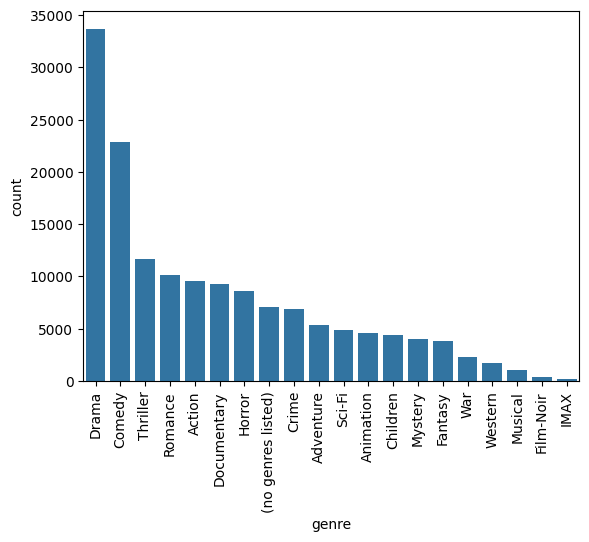

In [25]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [26]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [27]:
print(type(X))
print(X[0].shape)

<class 'scipy.sparse._csr.csr_matrix'>
(1, 83239)


In [28]:
n_total = X.shape[0]*X.shape[1]
n_total

27550028025

In [29]:
n_ratings = X.nnz
n_ratings

33832162

In [30]:
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.12%


In [31]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

330975

In [32]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 33332 movies.
Least active user rated 1 movies.


In [33]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

83239

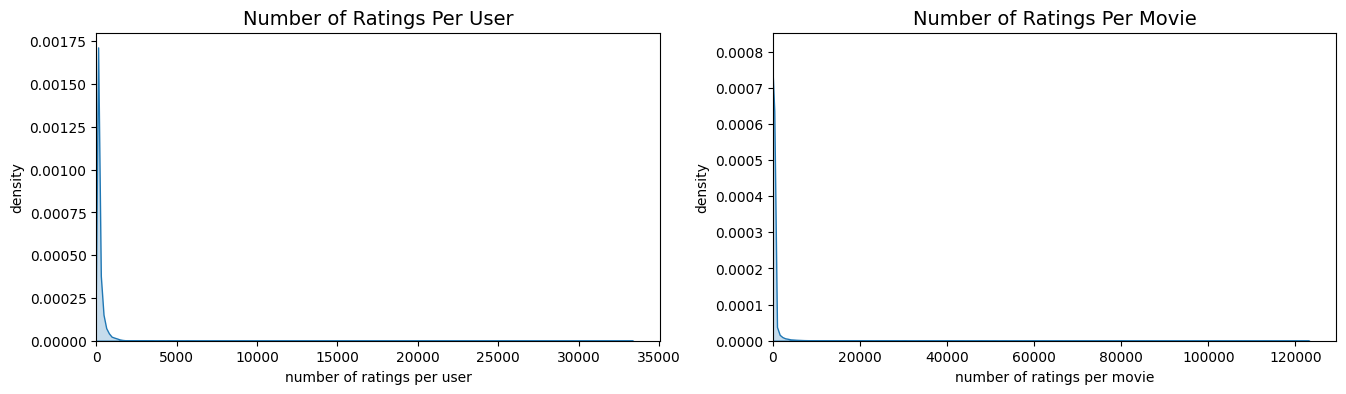

In [34]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [35]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [36]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [37]:
movie_id = 2

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Mask, The (1994)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Speed (1994)
Santa Clause, The (1994)
Beauty and the Beast (1991)


In [38]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 86537 unique movies in our movies dataset.


In [39]:
genres = set(g for G in movies['genres'] for g in G)
print(genres)
for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    


{'Adventure', 'Documentary', 'Horror', 'Thriller', '(no genres listed)', 'Action', 'Children', 'IMAX', 'Comedy', 'War', 'Animation', 'Film-Noir', 'Sci-Fi', 'Fantasy', 'Musical', 'Crime', 'Drama', 'Romance', 'Mystery', 'Western'}


In [40]:
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [41]:
movie_genres.head()

,Adventure,Documentary,Horror,Thriller,(no genres listed),Action,Children,IMAX,Comedy,War,Animation,Film-Noir,Sci-Fi,Fantasy,Musical,Crime,Drama,Romance,Mystery,Western
0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [42]:
movie_genres = np.array_split(movie_genres, 4)

movie_genres1 = movie_genres[0]
movie_genres2 = movie_genres[1]
movie_genres3 = movie_genres[2]
movie_genres4 = movie_genres[3]

In [43]:
# cosine_sim11 = cosine_similarity(movie_genres1, movie_genres1).astype(np.float16)
# np.save('cosine_similarities/cosine_sim11.npy', cosine_sim11)
# del cosine_sim11

# cosine_sim12 = cosine_similarity(movie_genres1, movie_genres2).astype(np.float16)
# np.save('cosine_similarities/cosine_sim12.npy', cosine_sim12)
# del cosine_sim12

# cosine_sim13 = cosine_similarity(movie_genres1, movie_genres3).astype(np.float16)
# np.save('cosine_similarities/cosine_sim13.npy', cosine_sim13)
# del cosine_sim13

# cosine_sim14 = cosine_similarity(movie_genres1, movie_genres4).astype(np.float16)
# np.save('cosine_similarities/cosine_sim14.npy', cosine_sim14)
# del cosine_sim14



# cosine_sim21 = cosine_similarity(movie_genres2, movie_genres1).astype(np.float16)
# np.save('cosine_similarities/cosine_sim21.npy', cosine_sim21)
# del cosine_sim21

# cosine_sim22 = cosine_similarity(movie_genres2, movie_genres2).astype(np.float16)
# np.save('cosine_similarities/cosine_sim22.npy', cosine_sim22)
# del cosine_sim22

# cosine_sim23 = cosine_similarity(movie_genres2, movie_genres3).astype(np.float16)
# np.save('cosine_similarities/cosine_sim23.npy', cosine_sim23)
# del cosine_sim23

# cosine_sim24 = cosine_similarity(movie_genres2, movie_genres4).astype(np.float16)
# np.save('cosine_similarities/cosine_sim24.npy', cosine_sim24)
# del cosine_sim24



# cosine_sim31 = cosine_similarity(movie_genres3, movie_genres1).astype(np.float16)
# np.save('cosine_similarities/cosine_sim31.npy', cosine_sim31)
# del cosine_sim31

# cosine_sim32 = cosine_similarity(movie_genres3, movie_genres2).astype(np.float16)
# np.save('cosine_similarities/cosine_sim32.npy', cosine_sim32)
# del cosine_sim32

# cosine_sim33 = cosine_similarity(movie_genres3, movie_genres3).astype(np.float16)
# np.save('cosine_similarities/cosine_sim33.npy', cosine_sim33)
# del cosine_sim33

# cosine_sim34 = cosine_similarity(movie_genres3, movie_genres4).astype(np.float16)
# np.save('cosine_similarities/cosine_sim34.npy', cosine_sim34)
# del cosine_sim34



# cosine_sim41 = cosine_similarity(movie_genres4, movie_genres1).astype(np.float16)
# np.save('cosine_similarities/cosine_sim41.npy', cosine_sim41)
# del cosine_sim41

# cosine_sim42 = cosine_similarity(movie_genres4, movie_genres2).astype(np.float16)
# np.save('cosine_similarities/cosine_sim42.npy', cosine_sim42)
# del cosine_sim42

# cosine_sim43 = cosine_similarity(movie_genres4, movie_genres3).astype(np.float16)
# np.save('cosine_similarities/cosine_sim43.npy', cosine_sim43)
# del cosine_sim43

# cosine_sim44 = cosine_similarity(movie_genres4, movie_genres4).astype(np.float16)
# np.save('cosine_similarities/cosine_sim44.npy', cosine_sim44)
# del cosine_sim44


In [44]:
# cosine_sim = np.block([
#     [np.load('cosine_similarities/cosine_sim11.npy'), np.load('cosine_similarities/cosine_sim12.npy'), np.load('cosine_similarities/cosine_sim13.npy'), np.load('cosine_similarities/cosine_sim14.npy')],
#     [np.load('cosine_similarities/cosine_sim21.npy'), np.load('cosine_similarities/cosine_sim22.npy'), np.load('cosine_similarities/cosine_sim23.npy'), np.load('cosine_similarities/cosine_sim24.npy')],
#     [np.load('cosine_similarities/cosine_sim31.npy'), np.load('cosine_similarities/cosine_sim32.npy'), np.load('cosine_similarities/cosine_sim33.npy'), np.load('cosine_similarities/cosine_sim34.npy')],
#     [np.load('cosine_similarities/cosine_sim41.npy'), np.load('cosine_similarities/cosine_sim42.npy'), np.load('cosine_similarities/cosine_sim43.npy'), np.load('cosine_similarities/cosine_sim44.npy')]
# ])
# np.save('cosine_similarities/cosine_sim.npy', cosine_sim)

In [45]:
cosine_sim = np.load('cosine_similarities/cosine_sim.npy')

In [46]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [47]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [48]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [49]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    rec = []
    for i in similar_movies:
        rec.append(movies['title'][i])
    return rec

In [50]:
print(get_content_based_recommendations('toy story'))

['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)', 'DuckTales: The Movie - Treasure of the Lost Lamp (1990)', 'Wild, The (2006)', 'Shrek the Third (2007)', 'Tale of Despereaux, The (2008)', 'Asterix and the Vikings (Astérix et les Vikings) (2006)']


In [51]:
svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(83239, 20)

In [52]:
print(movie_idx)

{'Toy Story (1995)': 0, 'Jumanji (1995)': 1, 'Grumpier Old Men (1995)': 2, 'Waiting to Exhale (1995)': 3, 'Father of the Bride Part II (1995)': 4, 'Heat (1995)': 5, 'Sabrina (1995)': 6, 'Tom and Huck (1995)': 7, 'Sudden Death (1995)': 8, 'GoldenEye (1995)': 9, 'American President, The (1995)': 10, 'Dracula: Dead and Loving It (1995)': 11, 'Balto (1995)': 12, 'Nixon (1995)': 13, 'Cutthroat Island (1995)': 14, 'Casino (1995)': 15, 'Sense and Sensibility (1995)': 16, 'Four Rooms (1995)': 17, 'Ace Ventura: When Nature Calls (1995)': 18, 'Money Train (1995)': 19, 'Get Shorty (1995)': 20, 'Copycat (1995)': 21, 'Assassins (1995)': 22, 'Powder (1995)': 23, 'Leaving Las Vegas (1995)': 24, 'Othello (1995)': 25, 'Now and Then (1995)': 26, 'Persuasion (1995)': 27, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28, 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29, 'Dangerous Minds (1995)': 30, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 31, 'Wings of Courage (1995)': 

In [57]:
def get_collab_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    movie_id = movie_inv_mapper[idx]
    similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=n_recommendations)
    movie_title = movie_titles[movie_id]
    rec = []
    for i in similar_movies:
        rec.append(movie_titles[i])
    return rec

In [58]:
def get_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    movie_id = movie_inv_mapper[idx]
    similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=n_recommendations)
    movie_title = movie_titles[movie_id]
    rec = []
    for i in similar_movies:
        rec.append(movie_titles[i])
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    for i in similar_movies:
        if movies['title'][i] not in rec:
            rec.append(movies['title'][i])
    return rec , movie_title

In [59]:
rec , title = get_recommendations('godzilla')

In [60]:
print(f"Because you watched {title} these are the top recommendation for you....")
for i in rec:
    print(i)


Because you watched Godzilla (1998) these are the top recommendation for you....
Blade (1998)
Batman & Robin (1997)
Sphere (1998)
Wild Wild West (1999)
Spawn (1997)
Deep Blue Sea (1999)
6th Day, The (2000)
Mortal Kombat: Annihilation (1997)
Street Fighter (1994)
Screamers (1995)
Johnny Mnemonic (1995)
Nemesis 2: Nebula (1995)
Virtuosity (1995)
Timecop (1994)
Blade Runner (1982)
Solo (1996)
Arrival, The (1996)
Terminator, The (1984)
Godzilla (1998)
